# Artificial Neural Network & Random Forest Modelling

### Main Research Question:

How should movie studios design their strategy to maximize the profit of their movies?

### Subquestions:

1 - Which model performs best at predicting profit?

2 - How does the production budget influence the profit of the movies?

3 - How does the theatre count influence the profit of a movie?

4 - How does the average run per theatre influence the profit?

5 - How does the runtime influence the profit of a movie?

# Table of contents 

###  Import libraries 

###  1. Creating the train, test, and validation splits & encoding
          
###  2. Encoding & Scaling 
         2.1 Train dataset
         2.2 Test dataset
         2.3 Validation dataset

###  3. Data Concatenation and Quality Check for Training-Validation Sets

###  4. Modelling
        4.1 Random forest
            4.1.1 Fitting model & hyperparametertuning
            4.1.2 Testing the model
        4.2 Artificial Neural Network
            4.2.1 Fitting the training dataset
            4.2.2 Evaluate on validation dataset
            4.2.3 Train model on train & validation dataset and make predictions on test set
            4.2.4 Hyperparametertuning
            4.2.5 Evaluate model on test dataset

###  5. Explainability
        5.1 ALE plots
        5.2 Answers to Research Questions




In [1]:
# importing useful libraries 
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.core.interactiveshell import InteractiveShell
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from plotnine import ggplot, aes, geom_point



import matplotlib.pyplot as plt
import os
import datetime
import pickle
import json
import random
import re

import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
from tensorflow.keras.optimizers import Adam
import keras
print('keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier


tensorflow: 2.15.0
keras: 2.12.0


In [2]:
#declaring constants for model behavior
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [3]:
# Loading the CSV file into a pandas DataFrame
file_path = r"c:\Users\leath\Documents\AUAS\0. Completed\7. AI Methods in Business\Resit\Merged_Cleaned.csv"
merged_df = pd.read_csv(file_path)

# Showing dataframe
merged_df.head()

,rating,metascore,userscore,Age,RelMonth,top_actors_count,genre,worldwide_box_office,production_budget,theatre_count,avg run per theatre,runtime,profit
0,PG-13,76,7.700,8,3,1,Thriller/Suspense,1.082864e+08,1.500000e+07,3391.00000,4.900000,103.0,9.328642e+07
1,R,61,6.900,12,9,0,Drama,9.876400e+05,3.642238e+07,3.00000,2.100000,100.0,-3.543474e+07
2,Not Rated,63,7.500,11,6,0,Comedy,2.524796e+07,3.642238e+07,13.00000,1.500000,91.0,-1.117442e+07
3,Not Rated,44,6.100,7,1,0,Drama,3.070000e+02,3.642238e+07,723.14704,4.124562,93.0,-3.642208e+07
4,Not Rated,65,6.886,9,5,0,Drama,4.701900e+04,3.642238e+07,723.14704,4.124562,88.0,-3.637536e+07


In [4]:
from sklearn.preprocessing import OneHotEncoder

# Columns for One-Hot Encoding
columns_to_encode = ['rating']

# Extract the columns to be encoded
data_to_encode = merged_df[columns_to_encode]

# Create the OneHotEncoder instance
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the data using the encoder
encoded_data = one_hot_encoder.fit_transform(data_to_encode)

# Get the feature names after encoding
encoded_column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded data and appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# Concatenate the encoded DataFrame with the original DataFrame
movie_df = pd.concat([merged_df.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the updated DataFrame with encoded columns
movie_df.head()

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,metascore,userscore,Age,RelMonth,top_actors_count,genre,worldwide_box_office,production_budget,theatre_count,avg run per theatre,...,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,76,7.700,8,3,1,Thriller/Suspense,1.082864e+08,1.500000e+07,3391.00000,4.900000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,61,6.900,12,9,0,Drama,9.876400e+05,3.642238e+07,3.00000,2.100000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,63,7.500,11,6,0,Comedy,2.524796e+07,3.642238e+07,13.00000,1.500000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44,6.100,7,1,0,Drama,3.070000e+02,3.642238e+07,723.14704,4.124562,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,6.886,9,5,0,Drama,4.701900e+04,3.642238e+07,723.14704,4.124562,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing the 'RelDate', 'year' and 'day' columns
merged_df.drop(['worldwide_box_office', 'rating', 'metascore', 'userscore', 'Age', 'RelMonth', 'top_actors_count', 'genre'], inplace=True, axis=1)

# 1. Creating the train, test, and validation splits & encoding

In [6]:
# Display the data types of each column
print(merged_df.dtypes)

production_budget      float64
theatre_count          float64
avg run per theatre    float64
runtime                float64
profit                 float64
dtype: object


In [7]:
# Splitting the df in 20% testing and 80% fitting data points.
X = merged_df.drop(['profit'], axis=1)
y = merged_df['profit']

# Splitting the dataset into training and testing sets into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further splitting  the fitting set into training and validation sets (80% train, 20% validation)
# This means 80% of the fitting dataset is used for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Encoding & Scaling 

## 2.1 Train dataset

In [8]:
# Display the first few rows of the final training DataFrame
X_train.head()

,production_budget,theatre_count,avg run per theatre,runtime
7487,3.642238e+07,723.14704,4.124562,82.0
3729,2.000000e+07,5.00000,7.200000,128.0
7302,3.642238e+07,1.00000,3.500000,85.0
7256,4.000000e+06,2700.00000,2.800000,88.0
459,3.642238e+07,51.00000,3.800000,90.0


In [9]:
# Scaling the X_train data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['production_budget', 'theatre_count', 'avg run per theatre','runtime']

# Fit the scaler on the specified columns of the training data
standard_scaler.fit(X_test[columns_to_scale])

# Transform these columns in the training set
X_train_scaled_columns = standard_scaler.transform(X_train[columns_to_scale])

# Replace the original columns in train_set with their scaled versions
X_train[columns_to_scale] = X_train_scaled_columns


# Displaying the X_train data
X_train.head()

,production_budget,theatre_count,avg run per theatre,runtime
7487,-0.041748,-0.219710,-0.115449,-1.361141
3729,-0.590729,-0.795475,1.078786,1.680879
7302,-0.041748,-0.798682,-0.357974,-1.162748
7256,-1.125590,1.365206,-0.629794,-0.964356
459,-0.041748,-0.758595,-0.241480,-0.832094


In [10]:
# Scaling the y_train data
# Reshaping the values
y_train.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_train.values.reshape(-1, 1))

# Transform these columns in the training set &  replace the original columns in train_set with their scaled versions
y_train_set = standard_scaler.transform(y_train.values.reshape(-1, 1))
y_train_set

array([[-0.24984327],
       [ 3.50370332],
       [-0.24984327],
       ...,
       [-0.24984327],
       [-0.22627701],
       [-0.24984327]])

## 2.2 Validation dataset

In [11]:
# Display the first few rows of the final validation DataFrame
X_val.head()

,production_budget,theatre_count,avg run per theatre,runtime
1958,3.642238e+07,2.00000,3.500000,85.0
3201,1.800000e+07,1858.00000,2.800000,102.0
6302,4.800000e+07,3594.00000,4.600000,118.0
1987,3.642238e+07,723.14704,4.124562,126.0
3020,3.642238e+07,3.00000,2.800000,124.0


In [12]:
# Scaling the X_val data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['production_budget', 'theatre_count', 'avg run per theatre','runtime']

# Fit the scaler on the specified columns of the validation data
standard_scaler.fit(X_val[columns_to_scale])

# Transform these columns in the validation set
X_val_scaled_columns = standard_scaler.transform(X_val[columns_to_scale])

# Replace the original columns in val_set with their scaled versions
X_val[columns_to_scale] = X_val_scaled_columns

# Displaying the X_train data
X_val.head()

,production_budget,theatre_count,avg run per theatre,runtime
1958,-0.042725,-0.756947,-0.352704,-1.109280
3201,-0.659184,0.753131,-0.634110,-0.053793
6302,0.344692,2.165574,0.089507,0.939606
1987,-0.042725,-0.170208,-0.101624,1.436305
3020,-0.042725,-0.756133,-0.634110,1.312130


In [13]:
# Scaling the y_val data
# Reshaping the values
y_val.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_val.values.reshape(-1, 1))

# Transform these columns in the training set &  replace the original columns in train_set with their scaled versions
y_val_set = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_val_set

array([[-0.22549104],
       [-0.14712269],
       [ 2.15936131],
       ...,
       [ 0.17375642],
       [-0.22549104],
       [-0.43137001]])

## 2.3 Test dataset

In [14]:
# Display the first few rows of the final training DataFrame
X_test.head()

,production_budget,theatre_count,avg run per theatre,runtime
4561,3.642238e+07,2.00000,7.400000,82.000000
7067,2.000000e+08,4045.00000,6.800000,169.000000
2272,1.500000e+07,1751.00000,2.700000,110.000000
4525,3.642238e+07,723.14704,4.124562,81.000000
518,3.642238e+07,7.00000,7.800000,101.502993


In [15]:
# Scaling the X_test data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['production_budget', 'theatre_count', 'avg run per theatre','runtime']

# Fit the scaler on the specified columns of the training data
standard_scaler.fit(X_test[columns_to_scale])

# Transform these columns in the training set
X_test_scaled_columns = standard_scaler.transform(X_test[columns_to_scale])

# Replace the original columns in test_set with their scaled versions
X_test[columns_to_scale] = X_test_scaled_columns

In [16]:
# Scaling the y_test data
# Reshaping the values
y_test.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_test.values.reshape(-1, 1))

# Transform these columns in the training set & replace the original columns in test_set with their scaled versions
y_test_set = standard_scaler.transform(y_test.values.reshape(-1, 1))
y_test_set

array([[-0.44757312],
       [ 6.27346098],
       [-0.13501882],
       ...,
       [-0.24899046],
       [-0.42454713],
       [-0.18821449]])

# 3. Data Concatenation and Quality Check for Training-Validation Sets

In [17]:
# Concatenate training and validation features along the rows, resetting index to avoid duplicate indices
X_train_validation = pd.concat([X_train.reset_index(drop=True), X_val.reset_index(drop=True)], axis=0)

# Concatenate training and validation target variables using NumPy
y_train_validation = np.concatenate([y_train_set, y_val_set], axis=0)

# Check for any null (missing) values in the concatenated features
x_null_check = X_train_validation.isnull().values.any()

# Check for any NaN (Not a Number) values in the concatenated target variable
y_null_check = np.isnan(y_train_validation).any()

In [18]:
# Get the column order from 'X_test'
column_order = X_test.columns.tolist()

# Reorder 'X_train_validation' to match 'X_test'
X_train_validation = X_train_validation[column_order]

In [19]:
# Convert the y_train_validation NumPy array to a pandas DataFrame
y_train_validation_df = pd.DataFrame(y_train_validation, columns=['profit'])

# Display the DataFrame
y_train_validation_df

,profit
0,-0.249843
1,3.503703
2,-0.249843
3,0.032915
4,-0.249843
...,...
7170,-0.141440
7171,1.184436
7172,0.173756
7173,-0.225491


# 4. Modelling

## 4.1 Random Forest

### 4.1.1 Fitting model & hyperparametertuning

In [20]:
X_train_validation

,production_budget,theatre_count,avg run per theatre,runtime
0,-0.041748,-0.219710,-0.115449,-1.361141
1,-0.590729,-0.795475,1.078786,1.680879
2,-0.041748,-0.798682,-0.357974,-1.162748
3,-1.125590,1.365206,-0.629794,-0.964356
4,-0.041748,-0.758595,-0.241480,-0.832094
...,...,...,...,...
1430,-1.194585,-0.716266,-0.473307,-0.084651
1431,-0.592259,-0.743115,2.622169,1.870917
1432,0.244304,1.379617,-0.191900,1.684655
1433,-0.042725,-0.170208,-0.101624,-1.419717


In [21]:
column_list = X_train_validation.columns.tolist()
print(column_list)

['production_budget', 'theatre_count', 'avg run per theatre', 'runtime']


Grid Search will be done on the follwoing hyperparameters:

n_estimators: Number of trees in the forest

max_depth: Maximum depth (splits) of the individual decision trees

min_samples_split: Minimum number of samples (datapoints) required to split an internal node.

min_samples_leaf: Minimum number of samples (datapoints) required to be at a leaf node.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Your RandomForestRegressor definition
rf = RandomForestRegressor(n_jobs=-1, random_state=1)

# Hyperparameter grid for finer search
param_grid_finer = {
    "n_estimators": [x for x in range(10, 200, 10)],
    "max_depth": [x for x in range(5, 21, 5)],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Create a GridSearchCV object with RandomForestRegressor
grid_search_rf_finer = GridSearchCV(
    rf,
    param_grid=param_grid_finer,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5  # Number of cross-validation folds
)

# Fit the model
_ = grid_search_rf_finer.fit(X_train_validation, y_train_validation)

# Get the best estimator and score
best_estimator_finer = grid_search_rf_finer.best_estimator_
best_score_finer = grid_search_rf_finer.best_score_

# Output the results
print("Best Estimator (Finer Grid):", best_estimator_finer)
print("Best Score (Finer Grid):", best_score_finer)

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Estimator (Finer Grid): RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=60, n_jobs=-1, random_state=1)
Best Score (Finer Grid): -0.22675623802403638


With the best hyperparameters found, the model will be tested.

### 4.1.2 Testing the model

As the problem is a regression problem, evaluation metrics such as Mean Squared Error, Mean Absolute Error, Root Mean Squared Error and R-Aquared Error will be used.

Mean Squared Error (MSE):
    MSE measures the average squared difference between the actual and predicted values.
        
Mean Absolute Error (MAE):
    MAE measures the average absolute difference between the actual and predicted values.

Root Mean Squared Error (RMSE):
    RMSE is the square root of the MSE and provides an interpretable scale similar to the original target variable.

R-squared (R²):
    R² represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

In [23]:
from sklearn.model_selection import GridSearchCV

# Predictions using the trained Random Forest model on the test set
y_hat_test = grid_search_rf_finer.predict(X_test)

# Transforming predicted and actual values back to the original scale using inverse scaling
y_test_set_original_scale = standard_scaler.inverse_transform(y_test_set.reshape(-1, 1)).flatten()
y_hat_test_original_scale = standard_scaler.inverse_transform(y_hat_test.reshape(-1, 1)).flatten()

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse = mean_squared_error(y_test_set_original_scale, y_hat_test_original_scale)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae = mean_absolute_error(y_test_set_original_scale, y_hat_test_original_scale)
print("Mean Absolute Error:", mae)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test_set_original_scale, y_hat_test_original_scale))
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared = r2_score(y_test_set_original_scale, y_hat_test_original_scale)
print("R-squared:", r_squared)

Mean Squared Error: 4441099251958181.0
Mean Absolute Error: 24157887.062397715
Root Mean Squared Error: 66641573.00032901
R-squared: 0.7231571498527061


**Conclusion:**

Mean Squared Error (MSE):
        The quite large MSE value indicates that, on average, the squared differences between the actual and predicted profit values are substantial. This suggests that the model may have difficulty accurately predicting the precise numerical values of profit figures.

Mean Absolute Error (MAE):
        The MAE value suggests that, on average, the model's predictions are about 24,157,887 units away from the actual profit values. While this is a significant amount, the profit range is pretty wide, ranging between a min of 158,089,800 and a max of 2,608,900,000.

Root Mean Squared Error (RMSE):
        The RMSE value indicates the standard deviation of the prediction errors. This suggests that the majority of the model's prediction errors fall within ±66,641,573 units of the actual profit values. 

R-squared (R²):
        The R² value of 0.7231 indicates that the model explains approximately 72.31% of the variability in the profit data. While this suggests a reasonably good fit, there is still a considerable portion of unexplained variability.

In [24]:
# Putting the results in context 
# Getting more information about the data
merged_df['profit'].describe()

count    8.969000e+03
mean     1.798105e+07
std      1.187871e+08
min     -1.580898e+08
25%     -2.852238e+07
50%     -1.117442e+07
75%      9.767275e+06
max      2.608900e+09
Name: profit, dtype: float64

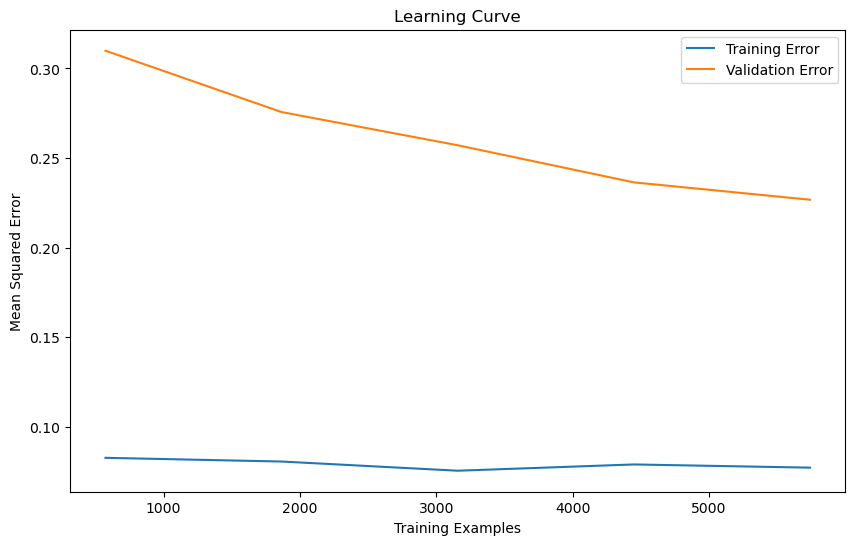

In [25]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error', n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    validation_scores_mean = -np.mean(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error')
    plt.plot(train_sizes, validation_scores_mean, label='Validation Error')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

# Assuming you have your RandomForestRegressor 'best_estimator', X_train, and y_train_validation
plot_learning_curve(best_estimator_finer, X_train_validation, y_train_validation, cv=5)

From the learning rate we can see that the validation error goes down over time and gets closer to the training error but never reaches it. The validation error is computed on a dataset that the model has not seen during training. It serves as a measure of how well the model generalizes to new, unseen data. AS visible from the learning rate but also the previous results, the accuracy of the model to predict on unseen data, could be better.

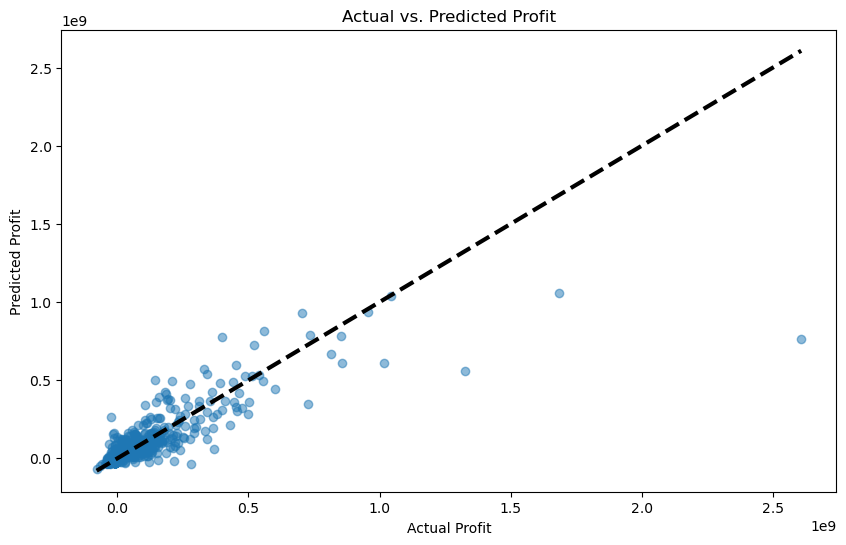

In [26]:
# Plotting the results
# Inverse transform to original scale
y_test_set_original = standard_scaler.inverse_transform(y_test_set.reshape(-1, 1)).flatten()
y_hat_test_original = standard_scaler.inverse_transform(y_hat_test.reshape(-1, 1)).flatten()

# Scatter plot of Actual vs. Predicted values on original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_set_original, y_hat_test_original, alpha=0.5)
plt.title('Actual vs. Predicted Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')

# Plot a line for perfect predictions
plt.plot([y_test_set_original.min(), y_test_set_original.max()], 
         [y_test_set_original.min(), y_test_set_original.max()], 'k--', lw=3)
plt.show()

**Conclusion:** The lower the values the better the prediction but the higher the values the less accurate the predictions are. Especially the predictions of the 3 highest profit values are far away from the actual values. The more spread the datapints are the less acccurate the predictions. IF the model would have a 100% accuracy, the points would all be lying on the line. This spread as seen in the graph indicates that the models predictions are not that precise and could be improved. This could for example be done by removing more outliers like the 3 highest profit datapoints. 

## 4.2 Artificial Neural Network

In [27]:
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 4


In [28]:
from keras import regularizers

# Define the neural network model class instance
# Create the model
simple_nn = Sequential()

# Add the first layer with L2 regularization
simple_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer with L2 regularization
simple_nn.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer with L2 regularization
simple_nn.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
simple_nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.01)

# Compile the model
simple_nn.compile(loss='mean_squared_error', optimizer=adam)

# Print model summary
print(simple_nn.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 149,057
Trainable params: 149,057
Non-trainable params: 0
_________________________________________________________________
None


### 4.2.1 Fitting the training dataset

In [29]:
# Checking the shape of the data
X_train.shape

(5740, 4)

In [30]:
y_train_set.shape

(5740, 1)

In [31]:
X_train_validation.shape

(7175, 4)

In [32]:
y_train_validation.shape

(7175, 1)

In [33]:
# Training a simple neural network using the fit method
simple_nn.fit(X_train, y_train_set, epochs=50, batch_size = 20)

Epoch 1/50

287/287 [==============================] - 4s 4ms/step - loss: 0.9260
Epoch 2/50
287/287 [==============================] - 1s 4ms/step - loss: 0.7218
Epoch 3/50
287/287 [==============================] - 1s 5ms/step - loss: 0.6008
Epoch 4/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5829
Epoch 5/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5430
Epoch 6/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5725
Epoch 7/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5247
Epoch 8/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5255
Epoch 9/50
287/287 [==============================] - 1s 4ms/step - loss: 0.5261
Epoch 10/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5282
Epoch 11/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5058
Epoch 12/50
287/287 [==============================] - 1s 3ms/step - loss: 0.5673
Epoch 13/50
287/287 [===

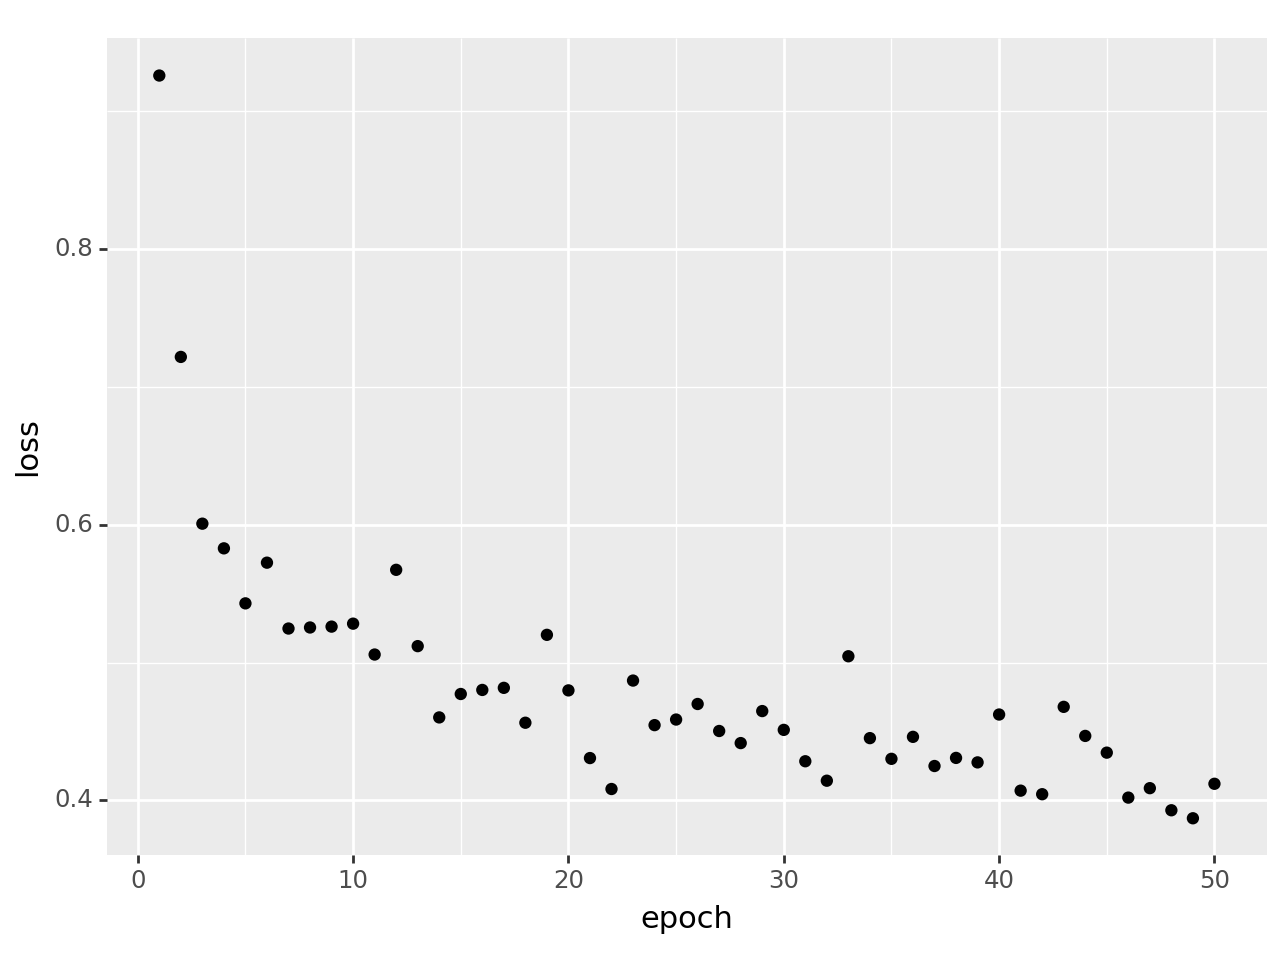

<Figure Size: (640 x 480)>

In [34]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 51))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

**Conclusion:** We can see on this graph that the loss os going down the more epochs the data is trained on. As the model goes through multiple epochs, it learns to recognize patterns and relationships in the training data. Initially, the model's predictions is far from the actual values, leading to a higher loss. With each epoch, the model fine-tunes its parameters, gradually improving its ability to make accurate predictions.

### 4.2.2 Evaluate on validation dataset

In [35]:
# Training the neural network with validation data using the fit method
simple_nn.fit(X_train, y_train_set, epochs=50, batch_size = 20, validation_data=(X_train_validation, y_train_validation))

Epoch 1/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4065 - val_loss: 0.3663
Epoch 2/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4328 - val_loss: 0.4285
Epoch 3/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4100 - val_loss: 0.3873
Epoch 4/50
287/287 [==============================] - 1s 4ms/step - loss: 0.3879 - val_loss: 0.5735
Epoch 5/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4009 - val_loss: 0.4698
Epoch 6/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4425 - val_loss: 0.4133
Epoch 7/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4190 - val_loss: 0.3593
Epoch 8/50
287/287 [==============================] - 1s 4ms/step - loss: 0.3910 - val_loss: 0.4607
Epoch 9/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4056 - val_loss: 0.4134
Epoch 10/50
287/287 [==============================] - 1s 4ms/step - loss: 0.4703 - val_loss: 0.4525

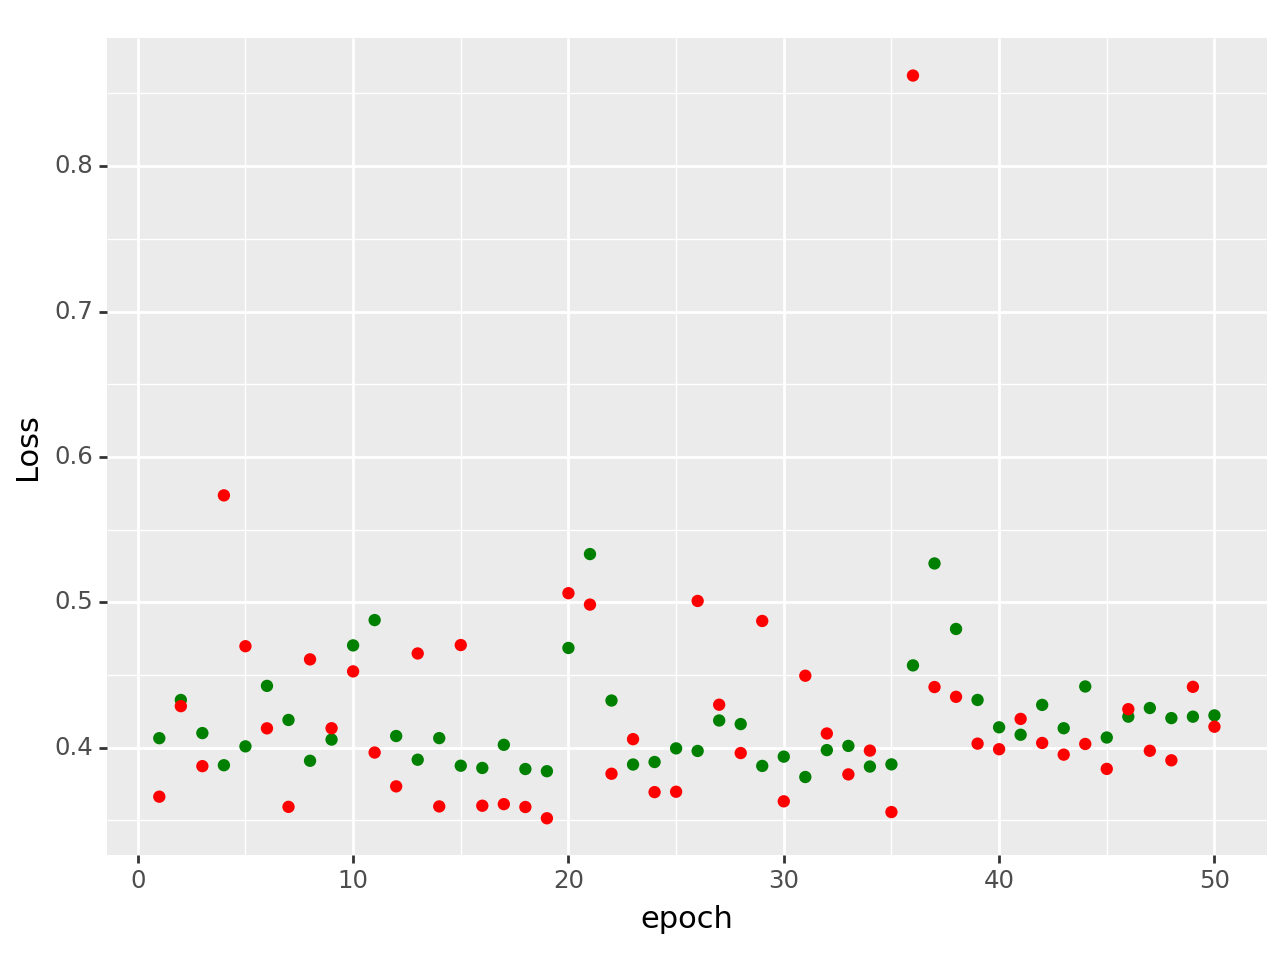

<Figure Size: (640 x 480)>

In [36]:
from plotnine import ggplot, aes, geom_point, scale_x_continuous, labs

# plot the training loss over epochs
def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch=np.arange(1, 51))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks=list(range(0, 150, 10))) +
        labs(y="Loss")
    )
    return p

plot_loss(simple_nn)


**Conclusion:** The term "loss" typically refers to the error between the model's predictions and the actual target values. A lower loss indicates better alignment between predictions and actual outcomes. The loss of the validation data is red and the one from the training data green. The loss is not really different from each dataset and it´s quite spread in both cases. This suggests that the model is performing similarly on both datasets in terms of minimizing the loss. This could also imply that there is some variability or noise in the data, leading to fluctuations in the loss values during training and validation. A certain amount of spread in the loss curves is normal, especially if the dataset is diverse or contains inherent variability. However, excessive spread might indicate challenges in model convergence or potential sensitivity to certain data points. The fact that the loss is not markedly different between training and validation datasets is a positive sign. It suggests that the model is not overfitting to the training data and is generalizing reasonably well to new, unseen data. The spread in the loss curves could be due to factors like the complexity of the model, the nature of the data, or the presence of outliers.

In [37]:
# Save the trained neural network model to disk
simple_nn.save('../dataset/simple_nn_model')

# Store the fitting history of the simple neural network to disk
print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets


INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets


Storing the fitting history of simple nn to disk


### 4.2.3 Train model on train & validation dataset and make predictions on test set

In [38]:
# showing the y of the test set. This variable contains the true or actual target values corresponding to the test set.
y_test_set

array([[-0.44757312],
       [ 6.27346098],
       [-0.13501882],
       ...,
       [-0.24899046],
       [-0.42454713],
       [-0.18821449]])

In [39]:
# Create the model
nn = Sequential()

# Add the first layer 
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer 
nn.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer
nn.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.01)

# Compile the model
nn.compile(loss='mean_squared_error', optimizer=adam)

# Train the neural network
nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size=20, verbose=0)

history = nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size=20, verbose=0)

# Make predictions on the test set
y_hat_test_nn = nn.predict(X_test)

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse_nn = mean_squared_error(y_test_set, y_hat_test_nn)
print("Mean Squared Error:", mse_nn)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae_nn = mean_absolute_error(y_test_set, y_hat_test_nn)
print("Mean Absolute Error:", mae_nn)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse_nn = np.sqrt(mean_squared_error(y_test_set, y_hat_test_nn))
print("Root Mean Squared Error:", rmse_nn)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared_nn = r2_score(y_test_set, y_hat_test_nn)
print("R-squared:", r_squared_nn)


57/57 [==============================] - 0s 2ms/step
Mean Squared Error: 0.41780211166328385
Mean Absolute Error: 0.22527560160891505
Root Mean Squared Error: 0.6463761379129677
R-squared: 0.5821978883367163


Conclusion:

Mean Squared Error (MSE): An MSE of 0.4178 indicates a relatively small average squared error. Lower MSE values are generally better, signifying that the model's predictions are close to the actual values on average.

Mean Absolute Error (MAE): With an MAE of 0.2253, it indicates that, on average, the model's predictions deviate by this amount from the true values. Similar to MSE, lower MAE values are desirable.

Root Mean Squared Error (RMSE): An RMSE of 0.6464 suggests that, on average, the model's predictions differ by approximately 0.6464 units from the true values. Again, lower RMSE values are preferred.

R-squared (R²): An R² of 0.5822 indicates that the model explains approximately 58.22% of the variance in the target variable. A higher R² value suggests a better fit. 

Overall, the model seems to be performing reasonably well, as indicated by the relatively low values of MSE, MAE, and RMSE. It suggests that, on average, the model's predictions are close to the actual values.

The R-squared value of 58.22% indicates a moderate level of explained variance. It suggests that the model captures a significant portion of the variability in the target variable but may not account for all factors influencing it.

### 4.2.4 Hyperparametertuning

To improve the models performance, hyperparametertuning will be performed.

First on epochs, batch size on number of neurons.

Epoch:  An epoch refers to one complete pass through the entire training dataset. During each epoch, the model processes all training examples, makes predictions, computes the loss, and updates its parameters to minimize the loss.

Batch size: The batch size is a hyperparameter that defines the number of training examples utilized in one iteration (one forward and one backward pass) during the training process of a neural network.

Number of neurons: The number of neurons (or units) in a layer represents the dimensionality of the layer's output space.

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor

# Define the model creation function
def create_model(layers=2, neurons=256, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03)))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.03)))

    model.add(Dense(1, activation='linear'))
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'epochs': [100, 150],
    'batch_size': [10, 20],
    'neurons': [20, 30]
}

# Create the KerasRegressor wrapper for scikit-learn
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the scoring metrics
scoring = {
    'mse': make_scorer(mean_squared_error),
    'mae': make_scorer(mean_absolute_error),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'r2': make_scorer(r2_score)
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='mse', cv=3, verbose=1)
grid_result = grid.fit(X_train_validation, y_train_validation)

# Print the best parameters and results
print("Best Parameters:", grid_result.best_params_)
print("Best MSE:", grid_result.best_score_)
print("Best MAE:", grid_result.cv_results_['mean_test_mae'][grid_result.best_index_])
print("Best RMSE:", grid_result.cv_results_['mean_test_rmse'][grid_result.best_index_])
print("Best R-squared:", grid_result.cv_results_['mean_test_r2'][grid_result.best_index_])


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\leath\AppData\Local\Temp\ipykernel_24436\3263345932.py:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best Parameters: {'batch_size': 10, 'epochs': 150, 'neurons': 20}
Best MSE: 0.6079103944260962
Best MAE: 0.33605018167643735
Best RMSE: 0.745881474813522
Best R-squared: 0.41935859553416605


Best Parameters: {'batch_size': 10, 'epochs': 150, 'neurons': 20}

Best MSE: 0.6079103944260962

Best MAE: 0.33605018167643735

Best RMSE: 0.745881474813522

Best R-squared: 0.41935859553416605

Before evaluating the measures, another hyperparametertuning will be done for number of layers and learning rate.

Number of layers: The number of layers in a neural network refers to the count of distinct layers, such as input layers, hidden layers, and output layers. Each layer contains a certain number of neurons or units, and these layers are connected by weights.

Learning rate: The learning rate controls the size of the steps taken during the optimization process. It determines how much the model's parameters (weights and biases) are updated in the direction that minimizes the loss function.

In [41]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Define a function to create the model
def create_model(layers=2, neurons_per_layer=20, learning_rate=0.01, l2_reg=0.03):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    
    for _ in range(layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    
    model.add(Dense(1, activation='linear'))
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

# Create a KerasRegressor with the create_model function
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'layers': [2, 3],
    'learning_rate': [0.001, 0.01],
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train_validation, y_train_validation)

# Print the best parameters and corresponding mean test score
print("Best parameters found: ", grid_result.best_params_)
print("Lowest RMSE found: ", np.sqrt(-grid_result.best_score_))

# Get the best model
best_model = grid_result.best_estimator_

# Make predictions on the test set using the best model
y_hat_test_best = best_model.predict(X_test)

# Calculate metrics with the best model
mse_best = mean_squared_error(y_test_set, y_hat_test_best)
mae_best = mean_absolute_error(y_test_set, y_hat_test_best)
rmse_best = np.sqrt(mse_best)
r_squared_best = r2_score(y_test_set, y_hat_test_best)

# Print metrics
print("Best Model Mean Squared Error:", mse_best)
print("Best Model Mean Absolute Error:", mae_best)
print("Best Model Root Mean Squared Error:", rmse_best)
print("Best Model R-squared:", r_squared_best)

C:\Users\leath\AppData\Local\Temp\ipykernel_24436\1847635283.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found:  {'layers': 2, 'learning_rate': 0.001}
Lowest RMSE found:  0.5258705825752389
Best Model Mean Squared Error: 0.2415015393166772
Best Model Mean Absolute Error: 0.20740701280149365
Best Model Root Mean Squared Error: 0.4914280611815703
Best Model R-squared: 0.7584984606833228


Best parameters found:  {'layers': 2, 'learning_rate': 0.001}

Lowest RMSE found:  0.5258705825752389

Best Model Mean Squared Error: 0.2415015393166772

Best Model Mean Absolute Error: 0.20740701280149365

Best Model Root Mean Squared Error: 0.4914280611815703

Best Model R-squared: 0.7584984606833228

### 4.2.5 Evaluate model

The best parameters on batch size, number of epochs, number of neurons, number of layers and learning rate were found and now used to build the final model and evaluate it´s performance.

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create the model
final_nn = Sequential()

# Add the first layer 
final_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer 
final_nn.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer
final_nn.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
final_nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.001)

# Compile the model
final_nn.compile(loss='mean_squared_error', optimizer=adam)

# Train the neural network with the best parameters
final_nn.fit(X_train_validation, y_train_validation, epochs=150, batch_size=10, verbose=0)

# Make predictions on the test set
y_hat_test_nn = final_nn.predict(X_test)

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse_nn = mean_squared_error(y_test_set, y_hat_test_nn)
print("Mean Squared Error:", mse_nn)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae_nn = mean_absolute_error(y_test_set, y_hat_test_nn)
print("Mean Absolute Error:", mae_nn)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse_nn = np.sqrt(mean_squared_error(y_test_set, y_hat_test_nn))
print("Root Mean Squared Error:", rmse_nn)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared_nn = r2_score(y_test_set, y_hat_test_nn)
print("R-squared:", r_squared_nn)


57/57 [==============================] - 0s 1ms/step
Mean Squared Error: 0.24815177581952355
Mean Absolute Error: 0.2151516250014384
Root Mean Squared Error: 0.49814834720143714
R-squared: 0.7518482241804765


Mean Squared Error (MSE): The MSE of 0.2481 suggests that the model's predictions are, on average, close to the true values. The MSE decreased after hyperparameter tuning, indicating that the model's predictions have lower squared errors compared to the original configuration.

Mean Absolute Error (MAE): The MAE of 0.2152 suggests that the model's predictions deviate, on average, by approximately 0.2152 units from the true values. he MAE also decreased after tuning, indicating a reduction in the average absolute errors between predictions and actual values.

Root Mean Squared Error (RMSE): The RMSE of 0.4981 suggests that, on average, the model's predictions differ by approximately 0.4981 units from the true values. The RMSE decreased, suggesting an improvement in the average magnitude of the prediction errors.

R-squared (R²): The R-squared value of 0.7518 indicates that the model explains approximately 75.18% of the variance in the target variable. This suggests a relatively good fit to the data. The R-squared value increased after hyperparameter tuning, indicating a higher proportion of variance explained by the model.

The model's performance significantly improved after hyperparameter tuning. The metrics collectively suggest that the model performs well. The low values of MSE, MAE, and RMSE indicate small errors in predictions, and the relatively high R-squared value indicates a good ability to explain the variance in the target variable.

<Figure size 1600x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Actual Profit')

Text(0, 0.5, 'Predicted Profit')

Text(0.5, 1.0, 'Actual vs Predicted Profit Scatterplot with Perfect Prediction Line')

<Axes: >

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot')

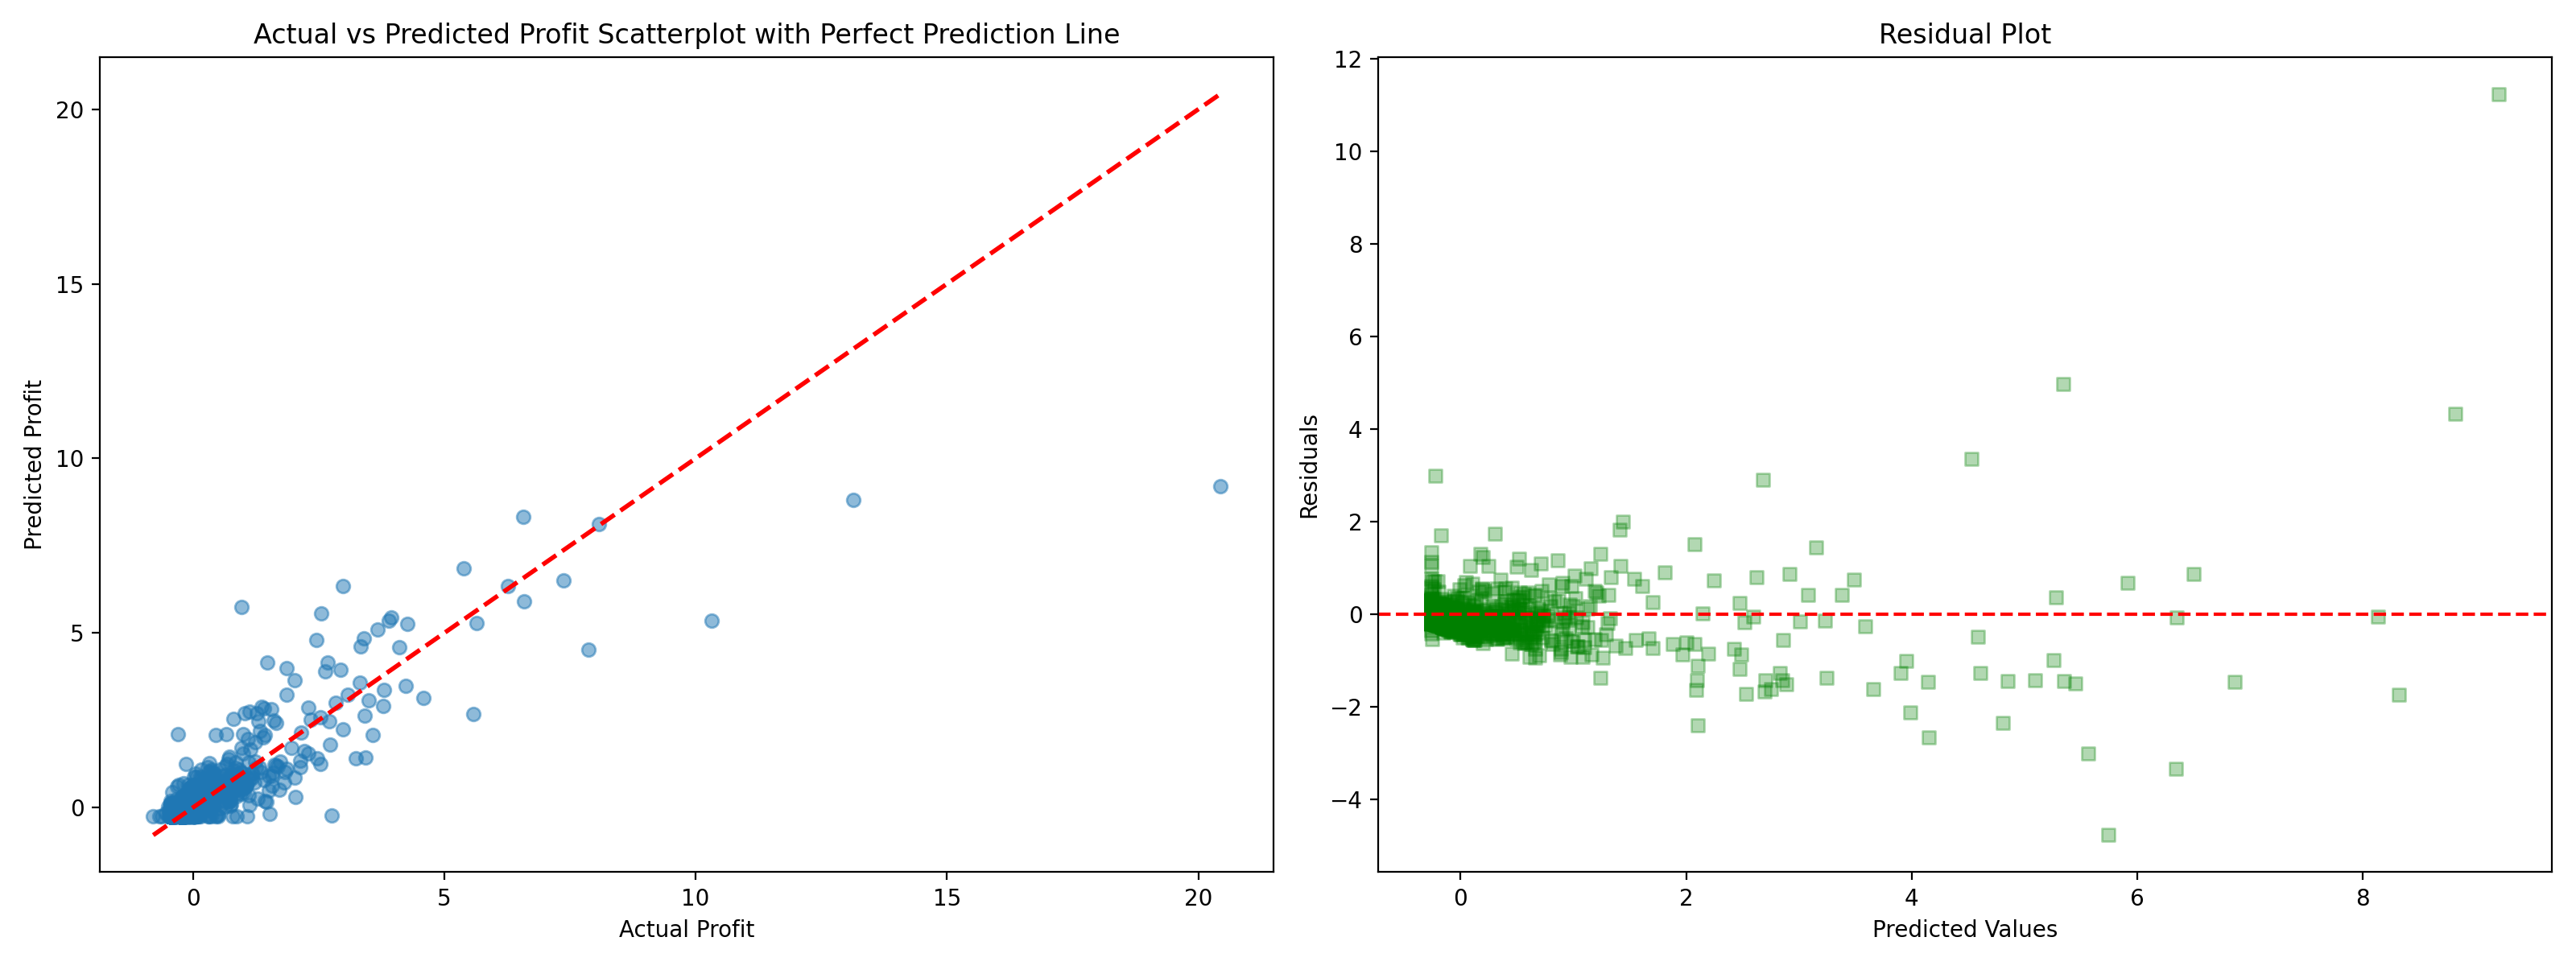

In [72]:

# Plotting actual vs predicted values in a scatterplot
plt.figure(figsize=(16, 6))

# Subplot 1: Actual vs Predicted Scatterplot
plt.subplot(1, 2, 1)
plt.scatter(y_test_set, y_hat_test_nn, alpha=0.5)
plt.plot([min(y_test_set), max(y_test_set)], [min(y_test_set), max(y_test_set)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit Scatterplot with Perfect Prediction Line')

# Subplot 2: Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test_set - y_hat_test_nn
plt.scatter(y_hat_test_nn, residuals, alpha=0.3, color='green', marker='s')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Residual Plot')
plt.tight_layout()

# Show the combined plots
plt.show()

**Conclusion:**

Actual vs. predicted profit Plot: The model seems to tend to predict more lower profit than it actually is, if the profit is really high. 

Residual Plot: Residuals are the differences between the observed values and the predicted values from the model. In this plot, we observe a somewhat random scatter of residuals, suggesting that the model predictions are not biased, which means, they are neither systematically too high nor too low. However, there are a few outliers, particularly for higher predicted values, which may indicate that the model does not capture all of the variability in the data, especially at the higher end of the range of predictions.

# 5. Explainability

When comparing the evaluation metrices of both models, it is visible that the Artificial Neural Network (r-squared = 76%) performs slightly better than the Random Forest (r-squared = 72%). Therefore, the effect of features will be evaluated only on the best performing model, the ANN, in the next section.

In [55]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [56]:
from alibi.explainers import ALE, plot_ale

## 5.1 ALE plots

<Figure size 800x600 with 0 Axes>

Text(0.0674643177986145, 0, '0.0655')

Text(0.06591102820634842, 1, '0.0639')

Text(0.04034253177046776, 2, '0.0383')

Text(0.017380953438580038, 3, '0.0154')

Text(0.5, 0, 'Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Top 10 Feature Importance Score for ANN')

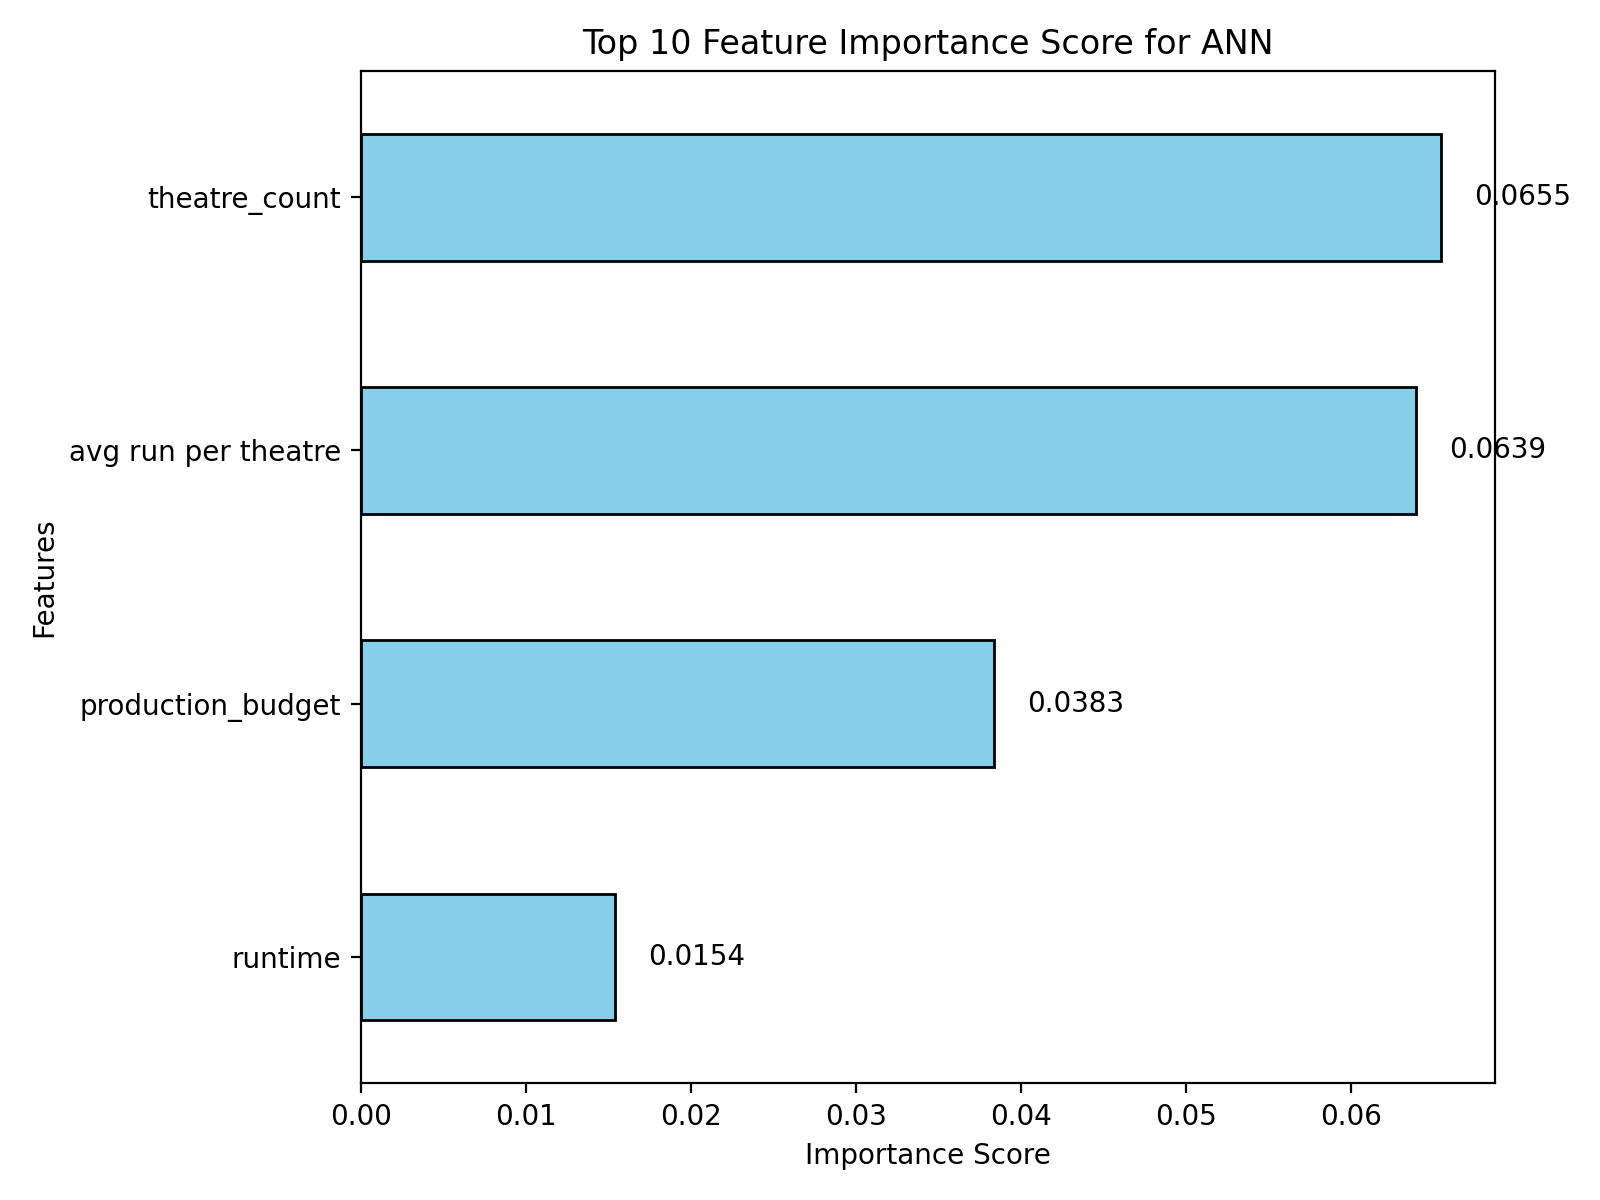

In [67]:
# Extracting the weights from the layers
weights = final_nn.get_weights()

# Extracting the weights of the first layer (assuming it's a dense layer)
dense_layer_weights = np.array(weights[0])

# Assuming X_train is your feature matrix with column names
feature_names = X_train.columns

# Check the number of features in X_train
num_features_in_X_train = X_train.shape[1]

# Check if the number of features in X_train matches the number of features in the neural network
num_features_in_nn = dense_layer_weights.shape[0]

if num_features_in_X_train != num_features_in_nn:
    raise ValueError("Number of features in X_train does not match the number of features in the neural network.")

# Calculating feature importances based on the weights
feature_importance = np.mean(np.abs(dense_layer_weights), axis=1)

# Creating a DataFrame with feature importances
feature_importance_df = pd.Series(feature_importance, index=feature_names, name='Importance')

# Plotting the top 10 important features in a horizontal bar chart
plt.figure(figsize=(8, 6)) 
ax = feature_importance_df.nlargest(10).plot(kind='barh', color='skyblue', edgecolor='black')

# Display importance values on the bars
for index, value in enumerate(feature_importance_df.nlargest(10)):
    ax.text(value + 0.002, index, f'{value:.4f}', va='center', fontsize=10, color='black')

# Set labels for x and y axes, and the title of the plot
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance Score for ANN')

# Adjust layout to avoid cutting off text
plt.tight_layout()

# Invert y-axis for better visualization
ax.invert_yaxis()

# Show the plot
plt.show()

**Conclusion:** Of all the for used features, the theatre count has the highest importance in the ANN model, followed by average run per theatre and production budget. Runtime is the least important feature.

The feature theatre_count has an importance score of 0.0655.
This indicates that within the specified range of theatre_count, it contributes moderately to the model's predictions.
A higher importance score suggests that changes in theatre_count have a relatively larger impact on the model's predictions compared to other features.

The feature avg run per theatre has an importance score of 0.0639.
Similar to theatre_count, it contributes moderately to the model's predictions within its range.

The feature production_budget has an importance score of 0.0383.
While still contributing, it has a relatively lower impact compared to theatre_count and avg run per theatre.
The model considers changes in production_budget, but they have a smaller effect on the predictions.

The feature runtime has the lowest importance score of 0.0154.
It has the smallest relative impact on the model's predictions within its range.
Changes in runtime have a comparatively smaller effect on the predictions compared to the other features.

Features with higher importance scores (e.g., theatre_count and avg run per theatre) play a more substantial role in influencing the model's predictions.

Features with lower importance scores (e.g., production_budget and runtime) are still considered by the model but have a relatively smaller impact.

<Figure size 800x600 with 0 Axes>

<Axes: >

57/57 [==============================] - 0s 3ms/step


<Axes: >

57/57 [==============================] - 0s 3ms/step


<Axes: >

57/57 [==============================] - 0s 4ms/step


<Axes: >

57/57 [==============================] - 0s 4ms/step


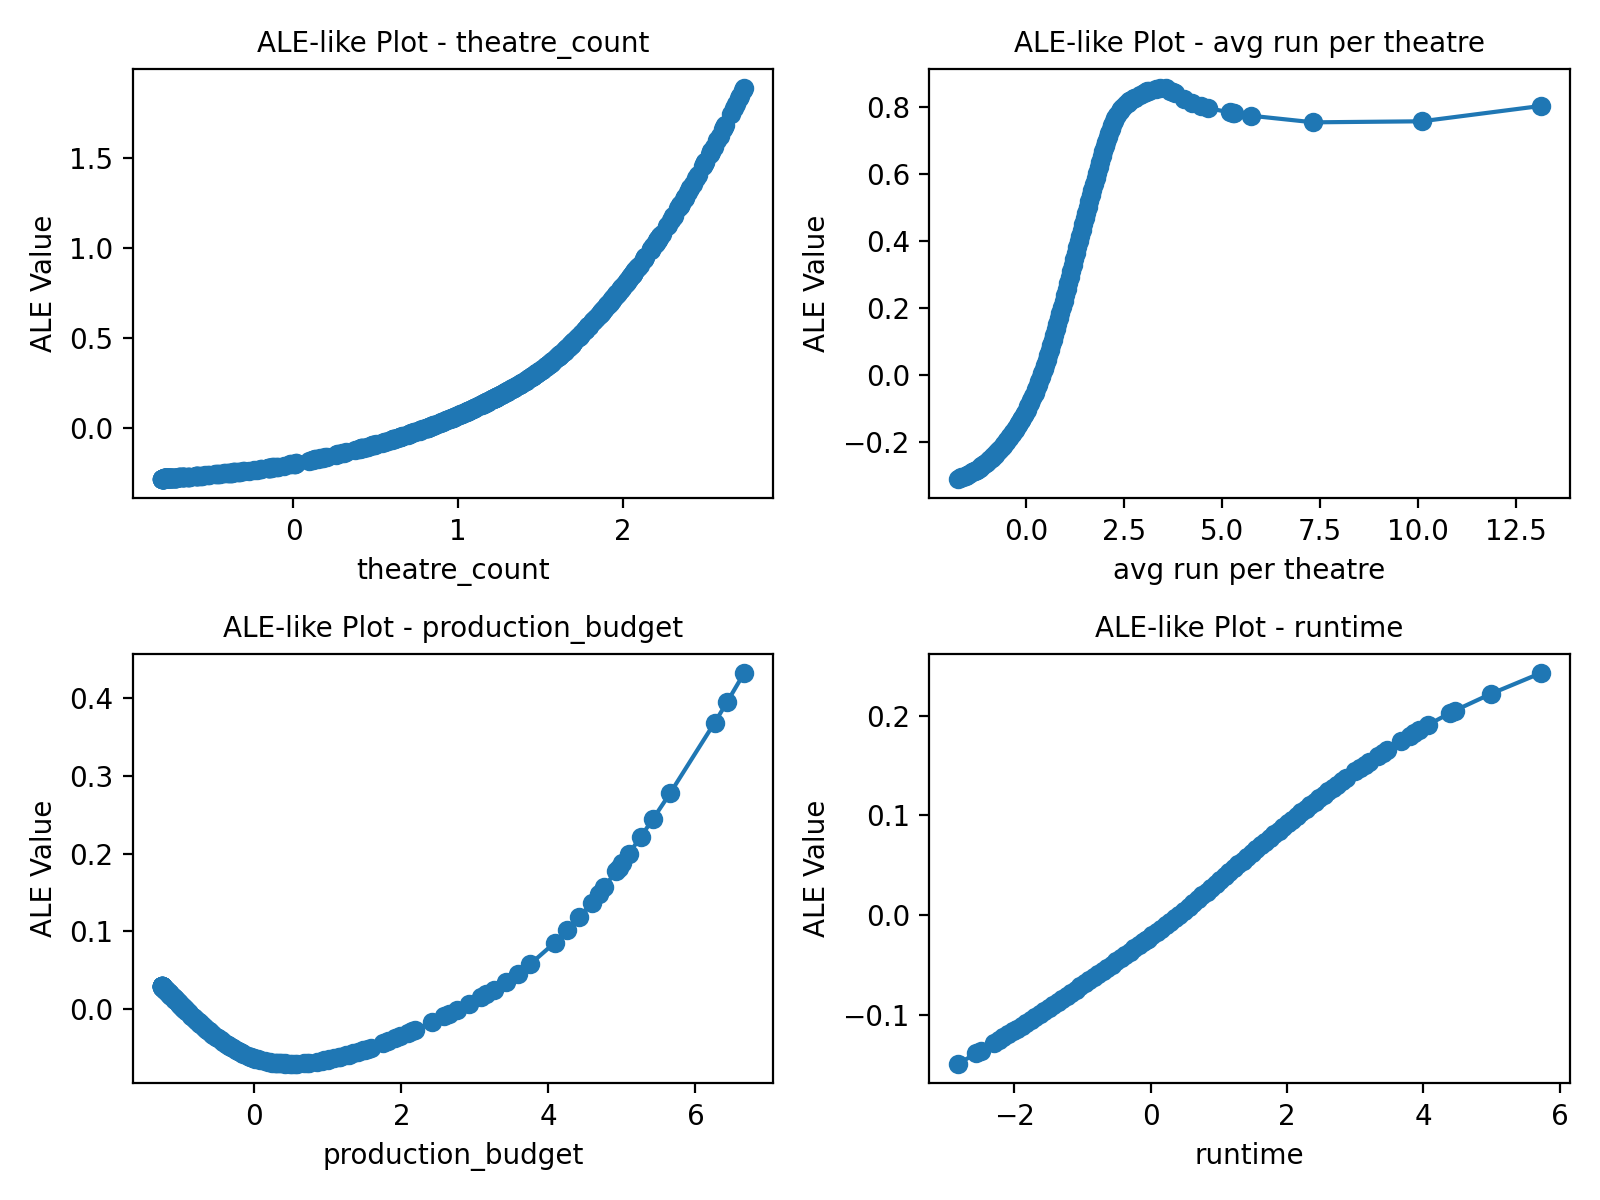

In [73]:
# Function to calculate and plot ALE for a given feature
def plot_ale(feature_to_calculate_ale):
    X_test_copy = X_test.copy()

    # Sort the unique values of the chosen feature
    unique_feature_values = np.sort(X_test_copy[feature_to_calculate_ale].unique())

    # Initialize lists to store ALE values
    ale_values = []

    # Calculate ALE for each unique feature value
    for value in unique_feature_values:
        # Create a copy of the input data with the current feature value replaced
        X_test_copy[feature_to_calculate_ale] = value

        # Make predictions on the modified dataset
        y_hat_test_nn_modified = final_nn.predict(X_test_copy)

        # Calculate the ALE value
        ale_value = np.mean(y_hat_test_nn_modified - y_hat_test_nn)

        # Append values to the list
        ale_values.append(ale_value)

    # Convert lists to numpy arrays for plotting
    ale_values = np.array(ale_values)

    # Plotting the ALE-like plot
    plt.plot(unique_feature_values, ale_values, marker='o')
    plt.xlabel(feature_to_calculate_ale)
    plt.ylabel("ALE Value")
    plt.title(f"ALE-like Plot - {feature_to_calculate_ale}", fontsize=10)  

# Create a 2x2 subplot grid
plt.figure(figsize=(8, 6))

# Plot ALE for each feature in a separate subplot
plt.subplot(2, 2, 1)
plot_ale("theatre_count")

plt.subplot(2, 2, 2)
plot_ale("avg run per theatre")

plt.subplot(2, 2, 3)
plot_ale("production_budget")

plt.subplot(2, 2, 4)
plot_ale("runtime")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

**Conclusion:**

For theatre count, the ALE plot exhibits a steep, almost exponential increase in ALE values as the theatre count increases. This indicates a strong positive relationship between the number of theatres a movie is shown in and its profit. 

The avg run per theatre plot also shows a strong positive relationship, with the ALE value increasing sharply as the average run per theatre increases. This suggests that movies that have longer runs in theatres tend to be more profitable. A low average amount of runs per theatre has a negative impact on profit. Then with small amounts of more runs per theatre the effect on the profit becomes positive and rises really quickly. At a certain amount more runs do not really have a higher positive impact on the profit. 

The ALE plot for production budget shows a U-shaped relationship initially, with a steep upward trend as the production budget increases. This suggests that at very low production budgets, increasing the budget is associated with a decrease in movie profit, but beyond a certain point, increases in the production budget are associated with significant increases in profit. This might indicate that beyond a certain threshold, investing more heavily in production can lead to greater profits.

The ALE plot for runtime shows a mostly positive relationship, with the ALE value increasing steadily as runtime increases. This indicates that movies with longer runtimes tend to have slightly higher profits, although the effect seems to be less dramatic than for theatre count or average run per theatre.



## 5.2 Answers to research questions

1 - Which model performs best at predicting profit?

The Neural Network performs better than the Random forest.

2 - Which features are best to use for predicting profit for movies?

Comparing the evaluation metrices of all four models, on average, both models (ANN & RF) using only numerical values, including production budget, theatre count, average run per theatre and runtime, with a correlation of more than 0.2 with the target variable are best in predicting the profit of movies. The ANN including also Genre and Ratings has around the same performance as the Random Forest without those features (r-squared = 72%). 

3 - How does the production budget influence the profit of the movies?

The very high production budgets effect the profit in the most positive way. But this is only the case if the budget exceedes a certain threshold. Before that it doesn´t really matter how high the production budget is, it will always have a slightly negative or no impact on the profit. Therefore, increases in the production budget may not immediately be associated with increases in profit, but beyond a certain level of costs, further increases in the production budget tend to be associated with higher profits. 

4 - How does the theatre count influence the profit of a movie?

The influence of the theatre count on profit rises exponentially. The more theatre counts, the higher the positive impact. In other words, movies shown in more theatres tend to have higher profits.

5 - How does the average run per theatre influence the profit?

Longer runs in theatres are associated with higher profits. Therefore extending the run of a movie in theatres can positively affect its profit.

6 - How does the runtime influence the profit of a movie?

The longer the runtime the higher the positive influence on the profit. But too short of a runtime has a negative impact on the profit. Generally, longer movies tend to be slightly more profitable.

**Main Research Question: How should movie studios design their strategy to maximize the profit of their movies?**


To create the most profit, movie studios should focus the most on having their movies played in as many movie theatres as possible. A broad distribution strategy is crucial for achieving higher profits through a wide-scale theatrical release. Also, the movie should be run as much as possible as those 2 features have the most influence on the profit which is also positive when it is high.

With the production budget, movie studios should also not hold back too much. Investing into a movie of high quality can pay off in the end. 

Although runtime has the lowest influence on a movies profit, movie studios should make sure that their movies are long. People seem to enjoy movies that keep them distracted from their real life as long as possible.